# A/B Email Campaign Testing

## Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm, mannwhitneyu

from statsmodels.stats.multitest import multipletests
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.power import tt_ind_solve_power
import statsmodels.formula.api as smf

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

from lifelines import KaplanMeierFitter, CoxPHFitter


## Load the Dataset

In [4]:
df = pd.read_csv("../data/processed/cleaned_email_Data.csv", parse_dates=['timestamp'])

In [5]:
df.head()

,user_id,variant,send_time,content_layout,account_age,feature_usage,user_segment,open,click,convert,timestamp,device
0,1,A,afternoon,text-heavy,216.0,48.0,active,1,1,0,2023-04-01 16:04:01,desktop
1,2,B,morning,text-heavy,1.0,20.0,new,1,1,0,2023-04-14 09:26:41,desktop
2,3,A,morning,balanced,357.0,47.0,active,0,0,0,2023-04-14 08:32:52,desktop
3,4,A,evening,balanced,262.0,33.0,active,1,1,0,2023-04-03 20:44:07,mobile
4,5,A,morning,visual-heavy,73.0,8.0,active,0,0,0,2023-04-12 11:52:06,desktop


## Define Helper Functions
Those functions will be used for effect size and confidence interval calculations

In [6]:
def calculate_effect_size(group1: np.ndarray, group2: np.ndarray) -> float:
    """Calculate Cohen's d effect size between two groups"""
    if np.std(group1) == 0 and np.std(group2) == 0:
        return 0
    if np.std(group1) == 0 or np.std(group2) == 0:
        return np.inf * np.sign(np.mean(group1) - np.mean(group2))
    
    n1, n2 = len(group1), len(group2)
    s_pooled = np.sqrt(((n1 - 1) * np.std(group1, ddof=1) ** 2 + 
                        (n2 - 1) * np.std(group2, ddof=1) ** 2) / (n1 + n2 - 2))
    return (np.mean(group1) - np.mean(group2)) / s_pooled

def calculate_confidence_interval(data: np.ndarray, confidence: float = 0.95) -> tuple:
    """Calculate confidence interval for the dataset"""
    mean = np.mean(data)
    se = np.std(data, ddof=1) / np.sqrt(len(data))
    z_value = norm.ppf((1 + confidence) / 2)
    return mean - z_value * se, mean + z_value * se 

## Calculate Basic Metrics

In [7]:
# create a copy of original df
metrics_df = df.copy()

# Fill NA values with 0 
for col in ['open', 'click', 'convert']:
    metrics_df[col] = metrics_df[col].fillna(0)

In [32]:
# Overall metrics
overall_metrics = {
    'sample_size': len(metrics_df),
    'open_rate': metrics_df['open'].mean(),
    'click_rate': metrics_df['click'].sum() / metrics_df['open'].sum() if metrics_df['open'].sum() > 0 else 0,
    'conversion_rate': metrics_df['convert'].mean(),
    'ctr': metrics_df['click'].sum() / len(metrics_df),
    'variant_sizes': dict(metrics_df['variant'].value_counts())
}

print("Overall Metrics:")
for k, v in overall_metrics.items():
    if k != 'variant_sizes':
        print(f"{k}: {v:.2%}" if isinstance(v, float) else f"{k}: {v}")
    else:
        print(f"{k}: {v}")

Overall Metrics:
sample_size: 500000
open_rate: 25.75%
click_rate: 27.53%
conversion_rate: 0.80%
ctr: 7.09%
variant_sizes: {'C': np.int64(170019), 'B': np.int64(165313), 'A': np.int64(164668)}


In [39]:
# Metrics by Variant
variant_metrics = metrics_df.groupby('variant').agg({
    'open': 'mean',
    'click': lambda x: x.sum() / metrics_df.loc[x.index, 'open'].sum(),
    'convert': 'mean'
}).rename(columns={'open': 'open_rate', 'click': 'click_rate', 'convert': 'conversion_rate'})

variant_metrics

,open_rate,click_rate,conversion_rate
variant,,,
A,0.295668,0.373036,0.015316
B,0.212573,0.296235,0.006745
C,0.264276,0.153098,0.002135


## Z-Test for Proportions

In [43]:
# Z-Test to compare Variant A with others (B & C)
primary_variant = 'A'
other_variants = [var for var in df['variant'].unique() if var != primary_variant]
z_test_results = []

for variant in other_variants:
    primary_data = metrics_df[metrics_df['variant'] == primary_variant]
    test_data = metrics_df[metrics_df['variant'] ==  variant]
    count1, count2 = primary_data['open'].sum(), test_data['open'].sum()
    nobs1, nobs2 = len(primary_data), len(test_data)
    z_stat, p_value = proportions_ztest([count1, count2], [nobs1, nobs2])

    rate1, rate2 = count1 / nobs1, count2 / nobs2
    abs_lift = rate1 - rate2
    rel_lift = (rate1 / rate2 - 1) * 100 if rate2 > 0 else float('inf')
    se = np.sqrt((rate1 * (1 - rate1) / nobs1) + (rate2 * (1 - rate2) / nobs2))
    z_critical = norm.ppf(1 - (1 - 0.95) / 2)
    margin = z_critical * se
    ci_lower, ci_upper = abs_lift - margin, abs_lift + margin
    mde = tt_ind_solve_power(effect_size=None, nobs1=nobs1, alpha=0.5, power=0.8, ratio=nobs2/nobs1)

    result = {
        'metric': 'open_rate',
        'primary_variant': primary_variant,
        'test_variant': variant,
        'primary_rate': rate1,
        'test_rate': rate2,
        'absolute_lift': abs_lift,
        'relative_lift': rel_lift,
        'z_statistic': z_stat,
        'p_value': p_value,
        'significant': p_value < 0.05,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'mde': mde
    }
    z_test_results.append(result)
    print(f"Z-test for open rate ({primary_variant} vs {variant}): "
          f"Lift: {abs_lift:.2%} ({rel_lift:.1f}%), p-value: {p_value:.4f}, Significant: {p_value < 0.05}")
    
# display results
z_test_df = pd.DataFrame(z_test_results)
display(z_test_df)

# save to csv
z_test_df.to_csv("../outputs/z_test_results.csv", index=False)

Z-test for open rate (A vs B): Lift: 8.31% (39.1%), p-value: 0.0000, Significant: True
Z-test for open rate (A vs C): Lift: 3.14% (11.9%), p-value: 0.0000, Significant: True


,metric,primary_variant,test_variant,primary_rate,test_rate,absolute_lift,relative_lift,z_statistic,p_value,significant,ci_lower,ci_upper,mde
0,open_rate,A,B,0.295668,0.212573,0.083095,39.090253,54.825303,0.000000e+00,True,0.080137,0.086053,0.005079
1,open_rate,A,C,0.295668,0.264276,0.031391,11.878211,20.226945,5.670973e-91,True,0.028350,0.034433,0.005044


## Post-Hoc Testing with FDR Correction

In [44]:
# Post-Hoc testing across segments
segments = ['user_segment', 'send_time', 'device', 'content_layout']
post_hoc_results= []

for segment in segments:
    if segment in df.columns:
        for value in df[segment].unique():
            for variant in df['variant'].unique():
                if variant != primary_variant:
                    group1 = df[(df['variant'] == primary_variant) & (df[segment] == value)]['open'].dropna()
                    group2 = df[(df['variant'] == variant) & (df[segment] == value)]['open'].dropna()

                    if len(group1) > 0 and len(group2) > 0:
                        stat, pval = mannwhitneyu(group1, group2, alternative='two-sided')
                        effect_size = calculate_effect_size(group1, group2)
                        ci_lower, ci_upper = calculate_confidence_interval(group1 - group2)
                        post_hoc_results.append({
                            'segment': segment,
                            'segment_value': value,
                            'variant': variant,
                            'p_value': pval,
                            'effect_size': effect_size,
                            'ci_lower': ci_lower,
                            'ci_upper': ci_upper
                        })

# Apply FDR Correction
post_hoc_df = pd.DataFrame(post_hoc_results)

if not post_hoc_df.empty:
    post_hoc_df['adjusted_p_value'] = multipletests(post_hoc_df['p_value'], method='fdr_bh')[1]
    significant_results = post_hoc_df[post_hoc_df['adjusted_p_value'] < 0.05]
    print("Significant Post-Hoc Results (FDR-corrected):")
    display(significant_results)
    significant_results.to_csv("../outputs/post_hoc_results.csv", index=False)

Significant Post-Hoc Results (FDR-corrected):


,segment,segment_value,variant,p_value,effect_size,ci_lower,ci_upper,adjusted_p_value
0,user_segment,active,B,0.000000e+00,0.238777,NaN,NaN,0.000000e+00
1,user_segment,active,C,1.356007e-282,0.142338,NaN,NaN,7.051237e-282
2,user_segment,new,B,3.822722e-33,-0.149714,NaN,NaN,5.846516e-33
3,user_segment,new,C,2.439453e-13,-0.090322,NaN,NaN,3.020275e-13
4,user_segment,inactive,B,5.270713e-48,0.130674,NaN,NaN,1.054143e-47
5,user_segment,inactive,C,3.762621e-166,-0.246332,NaN,NaN,1.397545e-165
6,user_segment,unknown,B,1.141107e-03,0.161101,NaN,NaN,1.236199e-03
8,send_time,afternoon,B,1.154884e-134,0.193868,NaN,NaN,3.753373e-134
9,send_time,afternoon,C,3.819832e-23,0.076868,NaN,NaN,4.965781e-23
10,send_time,morning,B,0.000000e+00,0.313879,NaN,NaN,0.000000e+00


## Propensity Score Matching

In [46]:
# Propensity score matching
features = ['send_time', 'device', 'content_layout', 'user_segment']

if all(col in df.columns for col in features):
    df_ps = pd.get_dummies(df[features], drop_first=True)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_ps)
    treatment = (df['variant'] != primary_variant).astype(int)

    ps_model = LogisticRegression()
    ps_model.fit(X_scaled, treatment)
    df['propensity_score'] = ps_model.predict_proba(X_scaled)[:, 1]

    # NN matching
    treated = df[df['variant'] != primary_variant]
    control = df[df['variant'] == primary_variant]
    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(control[['propensity_score']])
    distances, indices = nn.kneighbors(treated[['propensity_score']])
    matched_control = control.iloc[indices.flatten()]
    matched_df = pd.concat([treated.reset_index(drop=True), matched_control.reset_index(drop=True)])

    # Compare Metrics post-matching
    matched_metrics = matched_df.groupby('variant').agg({
        'open': 'mean',
        'click': 'mean',
        'convert': 'mean'
    })

    print("Metrics After Propensity Score Matching:")
    display(matched_metrics)
    matched_metrics.to_csv("../outputs/matched_metrics.csv")
else:
    print("Required columns for propensity score matching are missing.")

Metrics After Propensity Score Matching:


,open,click,convert
variant,,,
A,0.242569,0.199745,0.075835
B,0.212573,0.062971,0.006745
C,0.264276,0.040460,0.002135


## Survival Analysis

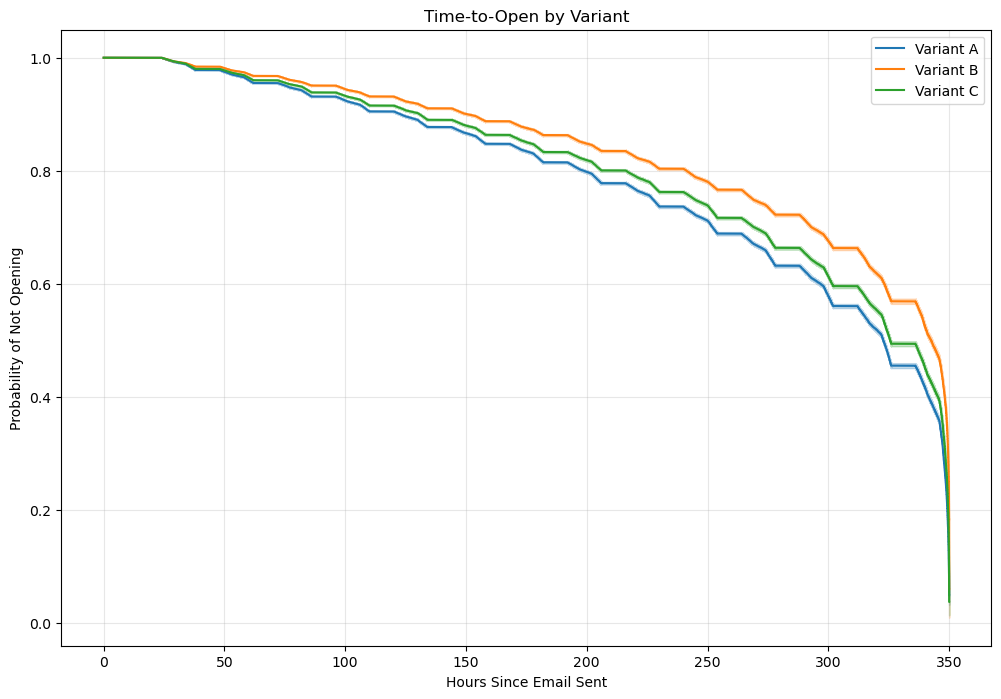

In [47]:
# Prepare Data
df_survival = df.dropna(subset=['open', 'timestamp']).copy()
sent_time = df_survival['timestamp']
max_time = sent_time.max()
df_survival['hours_to_open'] = (max_time - sent_time).dt.total_seconds() / 3600
df_survival['event'] = df_survival['open'].fillna(0).astype(int)

# Kaplan-Meier curves
plt.figure(figsize=(12, 8))
for variant in df_survival['variant'].unique():
    mask = df_survival['variant'] == variant
    kmf = KaplanMeierFitter()
    kmf.fit(df_survival[mask]['hours_to_open'], event_observed=df_survival[mask]['event'], label=f"Variant {variant}")
    kmf.plot_survival_function()
plt.title("Time-to-Open by Variant")
plt.xlabel('Hours Since Email Sent')
plt.ylabel("Probability of Not Opening")
plt.grid(True, alpha=0.3)
plt.show()

In [49]:
# Cox proportional hazards model
cox_df = df_survival[['hours_to_open', 'event', 'variant', 'user_segment', 'send_time', 'device', 'content_layout']]
cox_df = pd.get_dummies(cox_df, columns=['variant', 'user_segment', 'send_time', 'device', 'content_layout'], drop_first=True)
cox_model = CoxPHFitter()
cox_model.fit(cox_df, duration_col='hours_to_open', event_col='event')

print("Cox Proportional Hazards Model Summary:")
cox_model.print_summary()

Cox Proportional Hazards Model Summary:


<lifelines.CoxPHFitter: fitted with 500000 total observations, 371240 right-censored observations>
             duration col = 'hours_to_open'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 500000
number of events observed = 128760
   partial log-likelihood = -1557194.19
         time fit was run = 2025-05-09 00:25:52 UTC

---
                             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                    
variant_B                   -0.33      0.72      0.01           -0.34           -0.32                0.71                0.73
variant_C                   -0.11      0.89      0.01           -0.12           -0.10                0.88                0.91
user_segment_inactive       -0.38      0.68      0.01           -0.40           -0.37                0.67                0.69
user_segment_new            -0.05      0.95      0.01           -0.07           -0.03                0.93                0.97
user_segment_unknown        -0.02      0.98      0.04           -0.10            0.05                0.91                1.05
send_time_evening           -0.09      0.92      0.01           -0.10           -0.07                0.90                0.93
send_time_morning           -0.15      0.86      0.01           -0.16           -0.13                0.85                0.88
device_mobile                0.00      1.00      0.01           -0.01            0.01                0.99                1.01
device_tablet                0.01      1.01      0.01           -0.01            0.03                0.99                1.03
content_layout_text-heavy   -0.01      0.99      0.01           -0.02            0.00                0.98                1.00
content_layout_visual-heavy  0.00      1.00      0.01           -0.01            0.02                0.99                1.02

                             cmp to      z      p  -log2(p)
covariate                                                  
variant_B                      0.00 -46.99 <0.005       inf
variant_C                      0.00 -17.10 <0.005    215.27
user_segment_inactive          0.00 -42.65 <0.005       inf
user_segment_new               0.00  -4.89 <0.005     19.92
user_segment_unknown           0.00  -0.59   0.56      0.84
send_time_evening              0.00 -11.13 <0.005     93.22
send_time_morning              0.00 -19.58 <0.005    281.31
device_mobile                  0.00   0.24   0.81      0.30
device_tablet                  0.00   1.33   0.18      2.46
content_layout_text-heavy      0.00  -1.32   0.19      2.41
content_layout_visual-heavy    0.00   0.43   0.66      0.59
---
Concordance = 0.55
Partial AIC = 3114410.38
log-likelihood ratio test = 4664.36 on 11 df
-log2(p) of ll-ratio test = inf